In [1]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import lmfit
from scipy.io import readsav

In [86]:
%load_ext autoreload
%autoreload 2

from DSTPolarimeterLib import MuellerMatrixMirror, MuellerMatrixRotation
from DSTPolarimeterPlotLib import *
from script_to_run_on_kipsua import Main
from MMSP2Lib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dtor = 0.017453292519943295

---

# MM_45

In [5]:
path = '/nwork/kouui/dstsp/data/calibration/save/mm45/m20170103_17511_MM.sav'
saveFile = readsav(path, verbose=True)

--------------------------------------------------
Date: Fri Jan 13 16:48:22 2017
User: kouui
Host: shachi.hida
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.0
--------------------------------------------------
Successfully read 10 records of which:
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 6 are of type VARIABLE
--------------------------------------------------
Available variables:
 - mm [<class 'numpy.ndarray'>]
 - wl [<class 'numpy.ndarray'>]
 - o [<class 'numpy.recarray'>]
 - p [<class 'numpy.recarray'>]
 - c [<class 'numpy.recarray'>]
 - s [<class 'numpy.recarray'>]
--------------------------------------------------


In [8]:
saveFile['wl']

array([  198.922,   199.395,   199.868, ...,  1115.523,  1115.939,
        1116.355])

In [10]:
saveFile['mm'].shape

(2068, 4, 4)

In [20]:
print("start: {} nm, end: {} nm".format(wl[650],wl[2050]))

start: 500.253 nm, end: 1109.278 nm


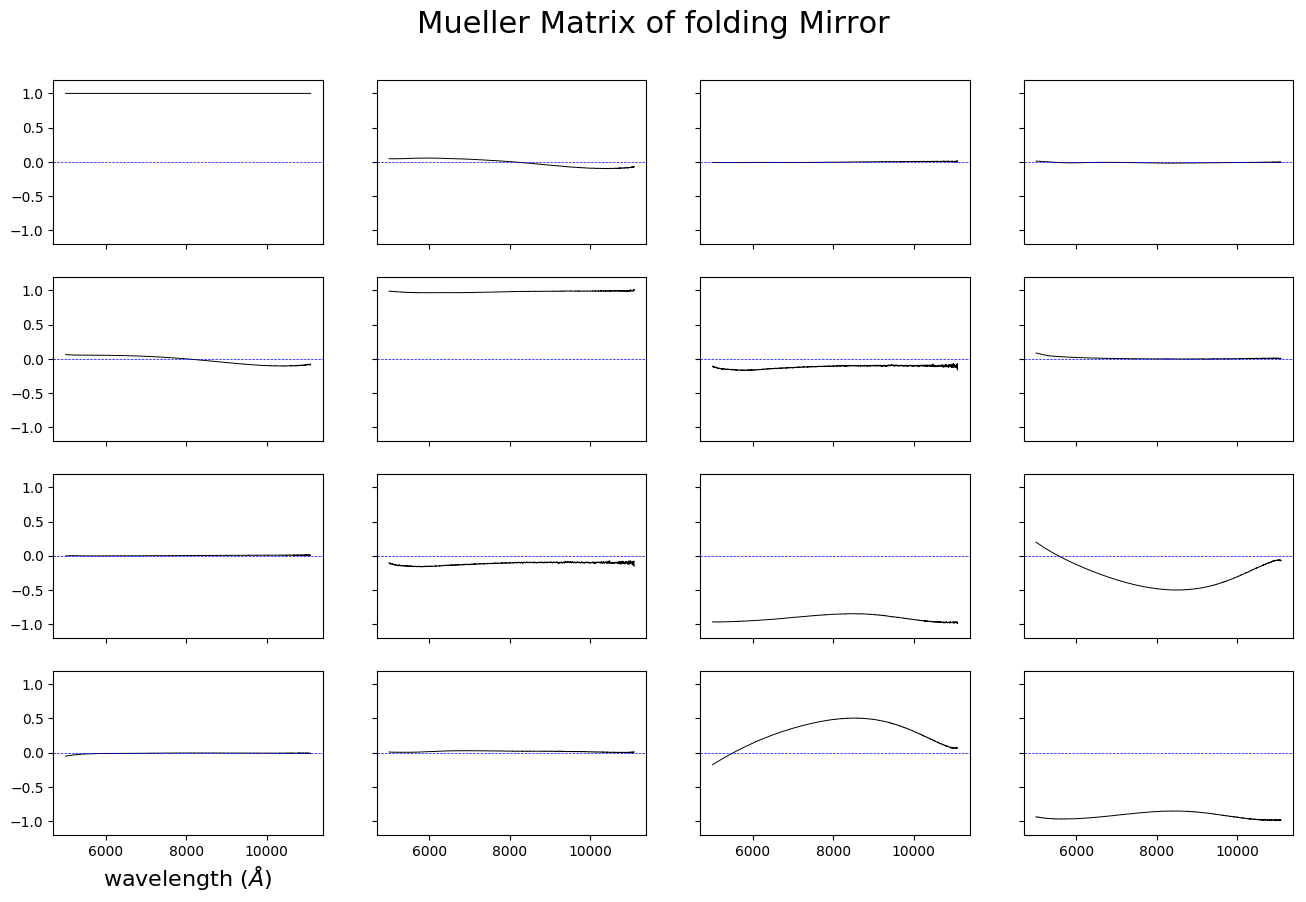

In [36]:
#
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=100, sharex=True, sharey=True)
mm = saveFile['mm']
wl = saveFile['wl']
x0, x1 = 650,2050


for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wl[x0:x1]*10, mm[x0:x1,i,j]/mm[x0:x1,0,0], '-k', linewidth=0.7)
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')

axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('Mueller Matrix of folding Mirror', x=0.5, y=0.95, fontsize=22);

## lowpass to denoise (not so good)

[https://algorithm.joho.info/programming/python/numpy-ifft-lowpass-denoise/](https://algorithm.joho.info/programming/python/numpy-ifft-lowpass-denoise/)

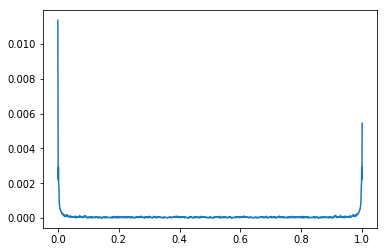

In [167]:
#
y_noise = mm[x0:x1,0,3]/mm[x0:x1,0,0]
N, dt = x1-x0, 1
# 周波数軸
freq = np.linspace(0, 1.0/dt, N)
# 高速フーリエ変換（周波数信号に変換）
F = np.fft.fft(y_noise)
# 正規化 + 交流成分2倍
F = F/(N/2)
F[0] = F[0]/2
# 配列Fをコピー
F2 = F.copy()

plt.plot(freq, np.abs(F))

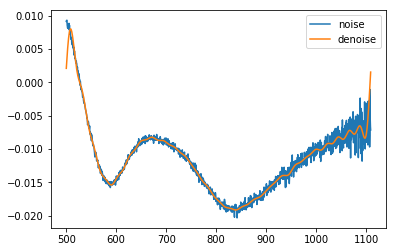

In [207]:
#
x = wl[x0:x1]
y_noise = mm[x0:x1,0,3]/mm[x0:x1,0,0]
N, dt = x1-x0, 1

# 周波数軸
freq = np.linspace(0, 1.0/dt, N)
# 高速フーリエ変換（周波数信号に変換）
F = np.fft.fft(y_noise)
# 正規化 + 交流成分2倍
F = F/(N/2)
F[0] = F[0]/2
# 配列Fをコピー
F2 = F.copy()

F2[(freq > 0.02)] = 0
y_denoise = np.fft.ifft(F2)
y_denoise = np.real(y_denoise*N)

plt.plot(x,y_noise, label="noise")
plt.plot(x,y_denoise, label="denoise")
plt.legend(loc="best");

## Savitzky-Golay filter to denoise (works well)

[http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html](http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html)

[https://stackoverflow.com/a/20642478](https://stackoverflow.com/a/20642478)

[https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html)

In [208]:
from scipy.signal import savgol_filter

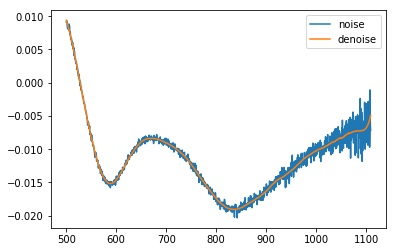

In [276]:
## do not apply this filter to a constant profile, ex, m00
x = wl[x0:x1]
y_noise = mm[x0:x1,0,3]/mm[x0:x1,0,0]
y_denoise = savgol_filter(y_noise, 201, 5)
plt.plot(x,y_noise, label="noise")
plt.plot(x,y_denoise, label="denoise")
plt.legend(loc="best");

## apply Savitzky-Golay filter to the whole mueller matrix

In [277]:
x0, x1 = 650,2050
N = x1-x0
mmFilter = np.ones((N,4,4))
wlFilter = saveFile['wl'][x0:x1].copy()

for i in range(4):
    for j in range(4):
        if i==0 and j==0:
            continue
        print("row: ",i,"col: ", j)
        temp = saveFile['mm'][x0:x1,i,j]/saveFile['mm'][x0:x1,0,0]
        mmFilter[:,i,j] = savgol_filter(temp, 201, 5)

row:  0 col:  1
row:  0 col:  2
row:  0 col:  3
row:  1 col:  0
row:  1 col:  1
row:  1 col:  2
row:  1 col:  3
row:  2 col:  0
row:  2 col:  1
row:  2 col:  2
row:  2 col:  3
row:  3 col:  0
row:  3 col:  1
row:  3 col:  2
row:  3 col:  3


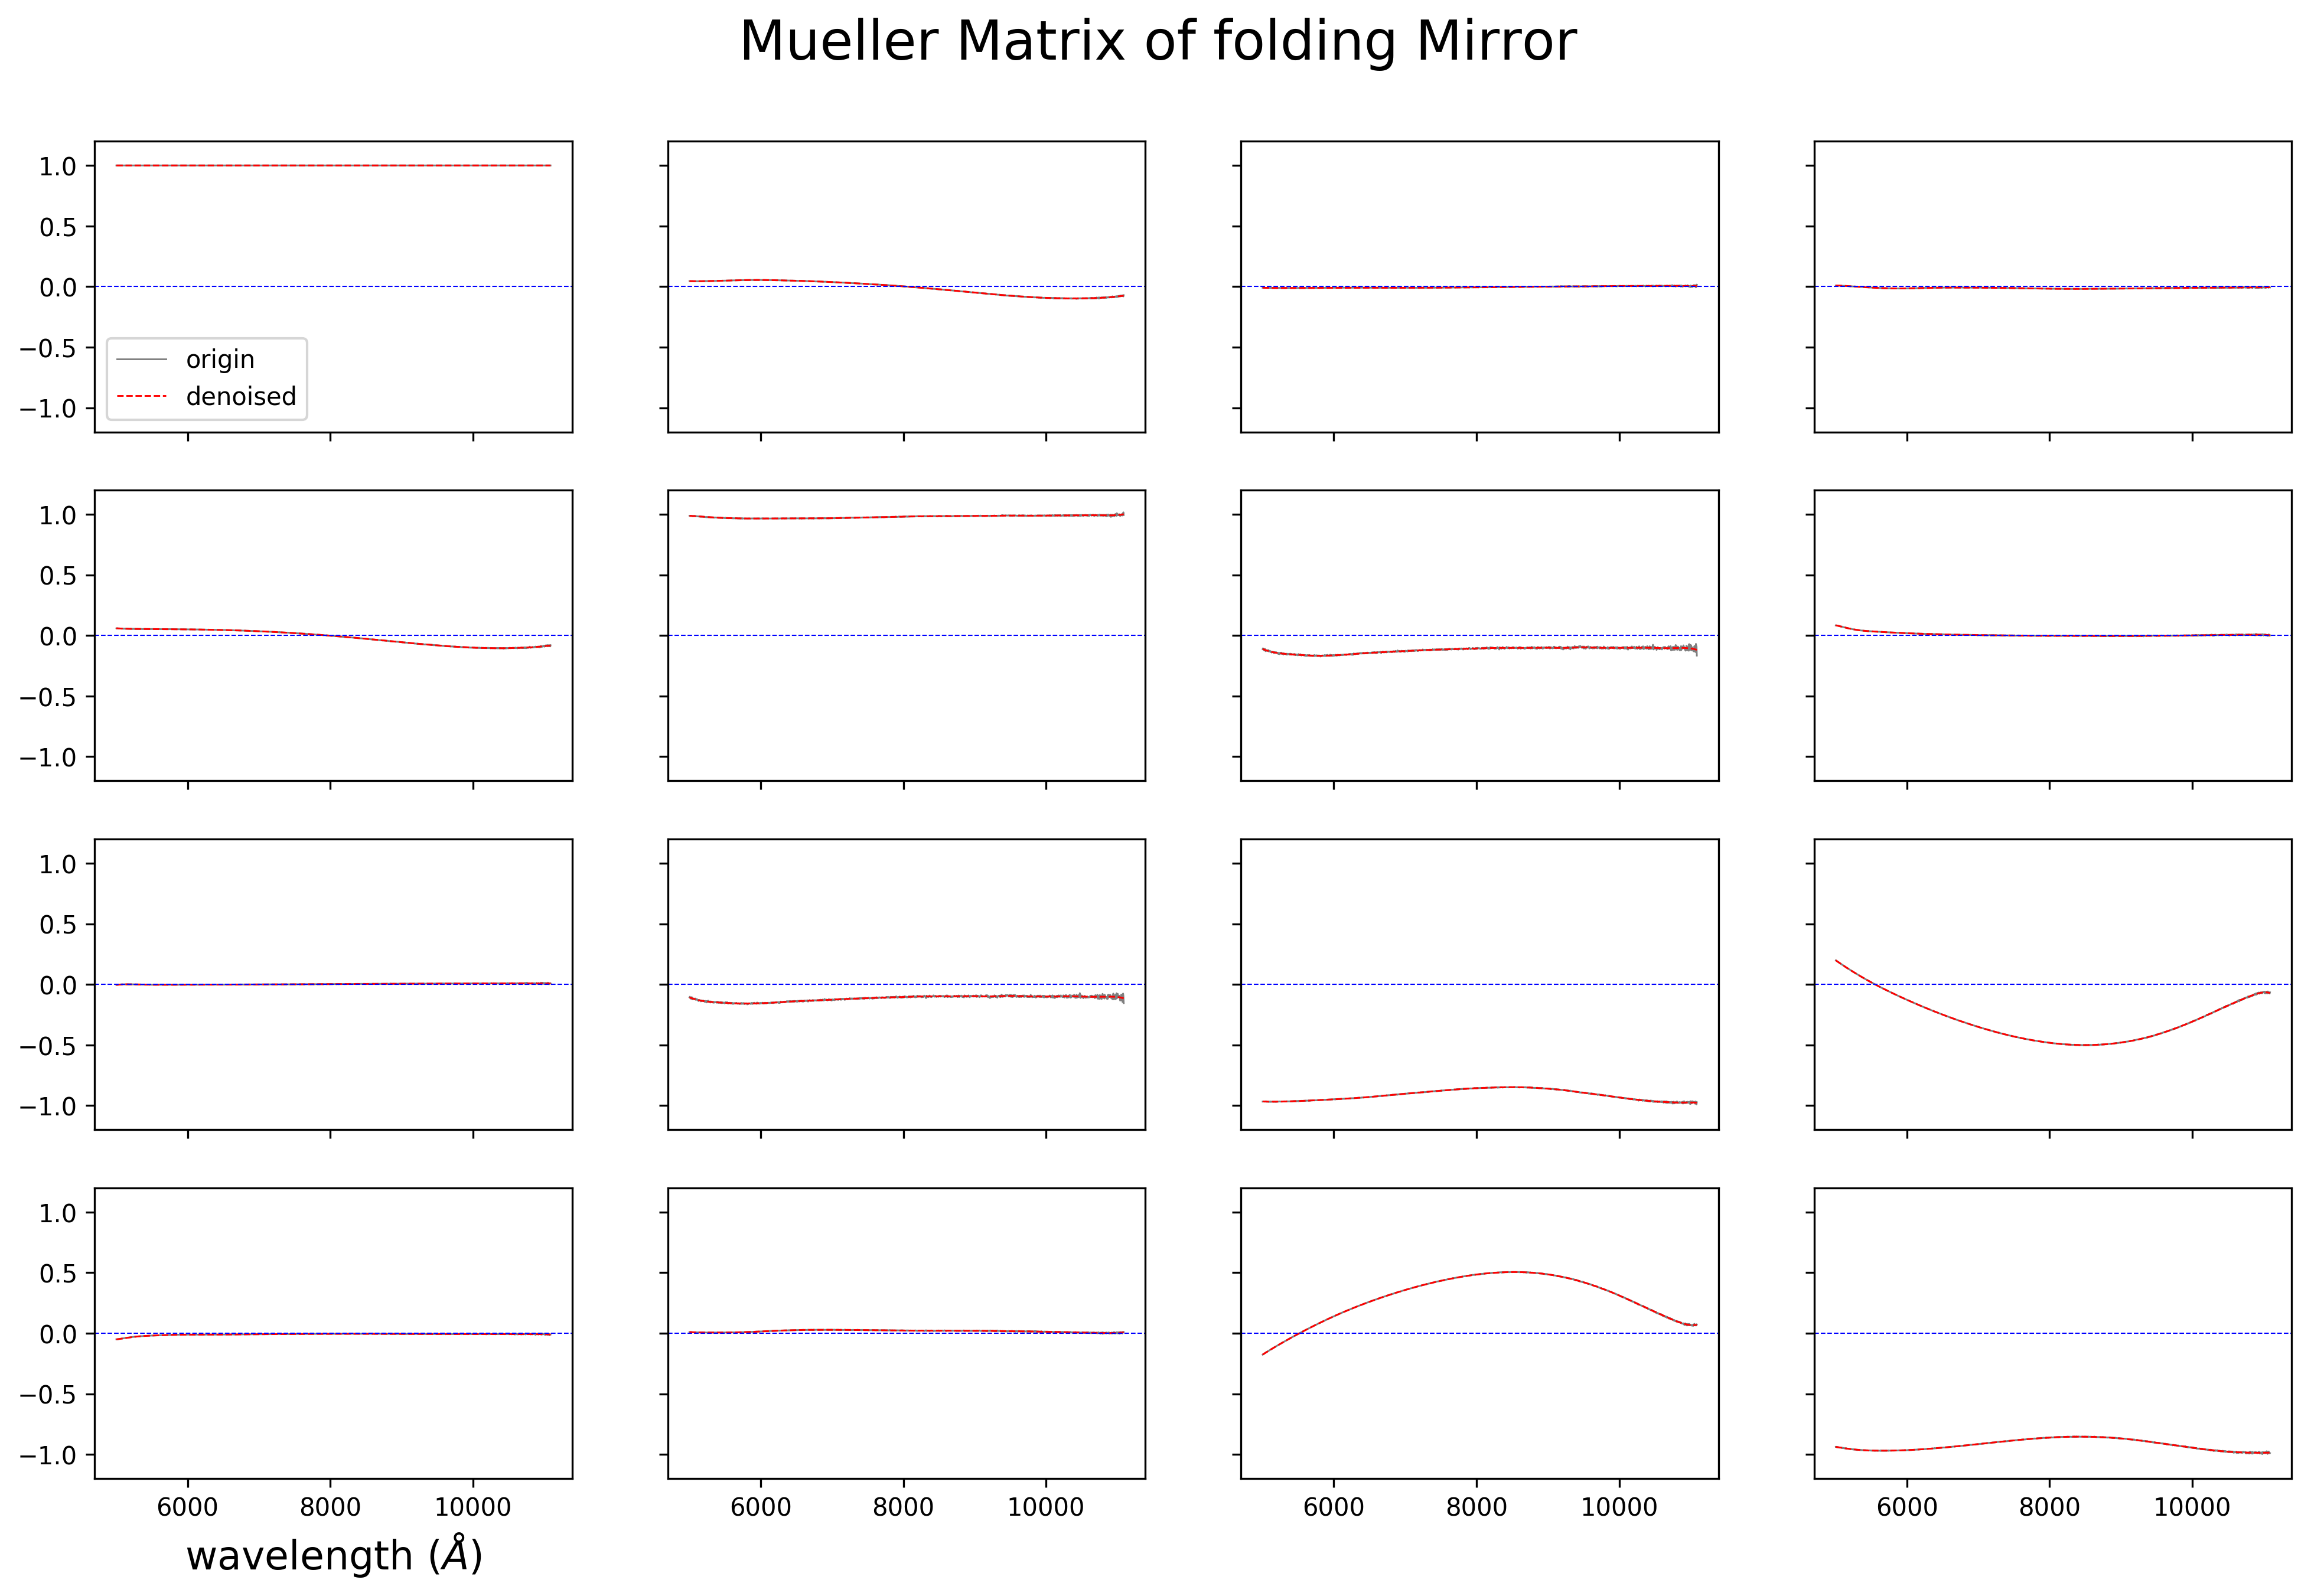

In [283]:
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=300, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(wl[x0:x1]*10, mm[x0:x1,i,j]/mm[x0:x1,0,0], '-k', linewidth=0.7, alpha=0.5, label="origin")
        ax.plot(wlFilter*10, mmFilter[:,i,j], '--r', linewidth=0.7, label="denoised")
        ax.set_ylim(-1.2,1.2)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')

axs[0,0].legend(loc='best')
axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('Mueller Matrix of folding Mirror', x=0.5, y=0.95, fontsize=22);

### check symmetry/anti-symmetry

mean deviation :  0.00506878256535


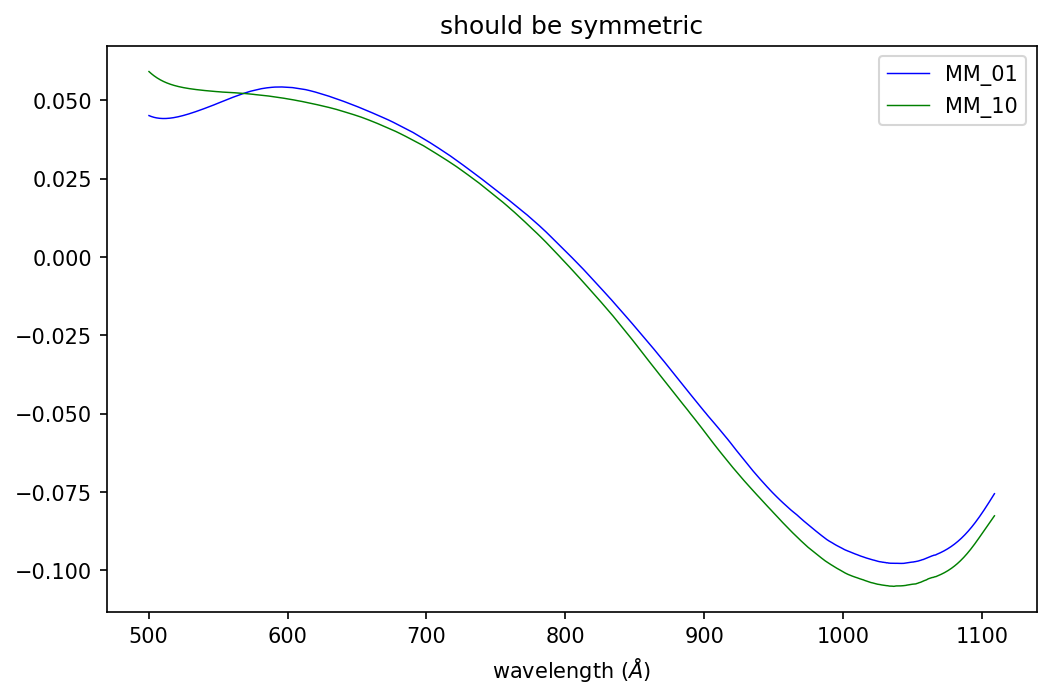

In [292]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 0, 1
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, mmFilter[:,c,r], '-g', linewidth=0.7, label="MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]-mmFilter[:,c,r]).mean() )

$M_{01}$ and $M_{10}$ are fine

mean deviation :  0.0063838211


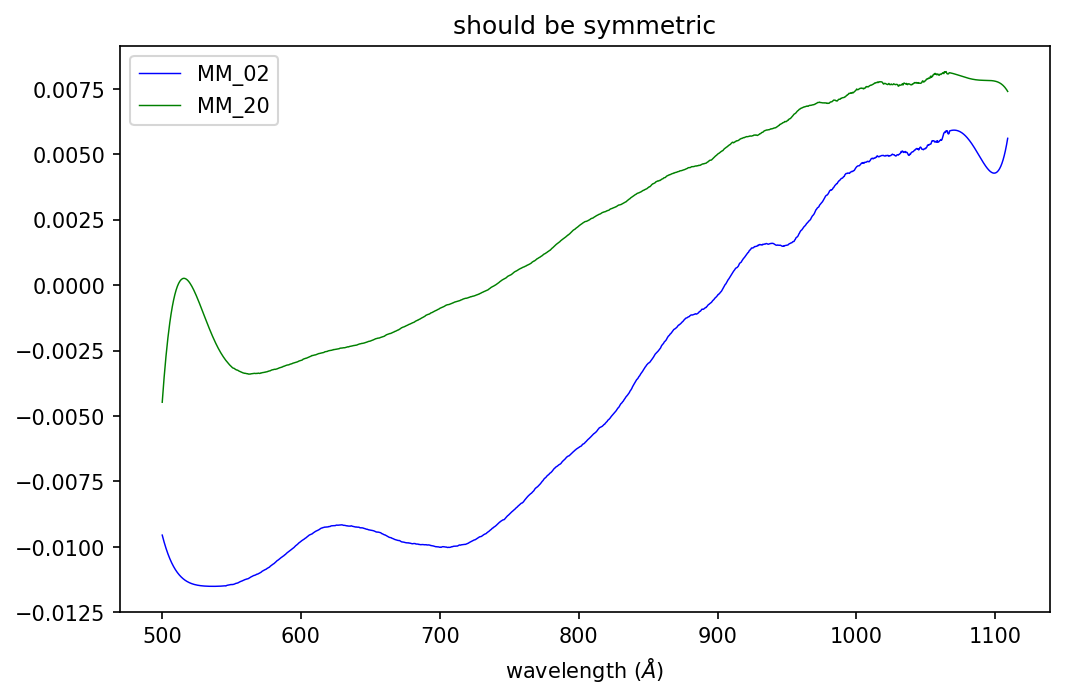

In [293]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 0, 2
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, mmFilter[:,c,r], '-g', linewidth=0.7, label="MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]-mmFilter[:,c,r]).mean() )

$M_{02}$ and $M_{20}$ is not good, ignore them during fitting process?

mean deviation :  0.00756264254902


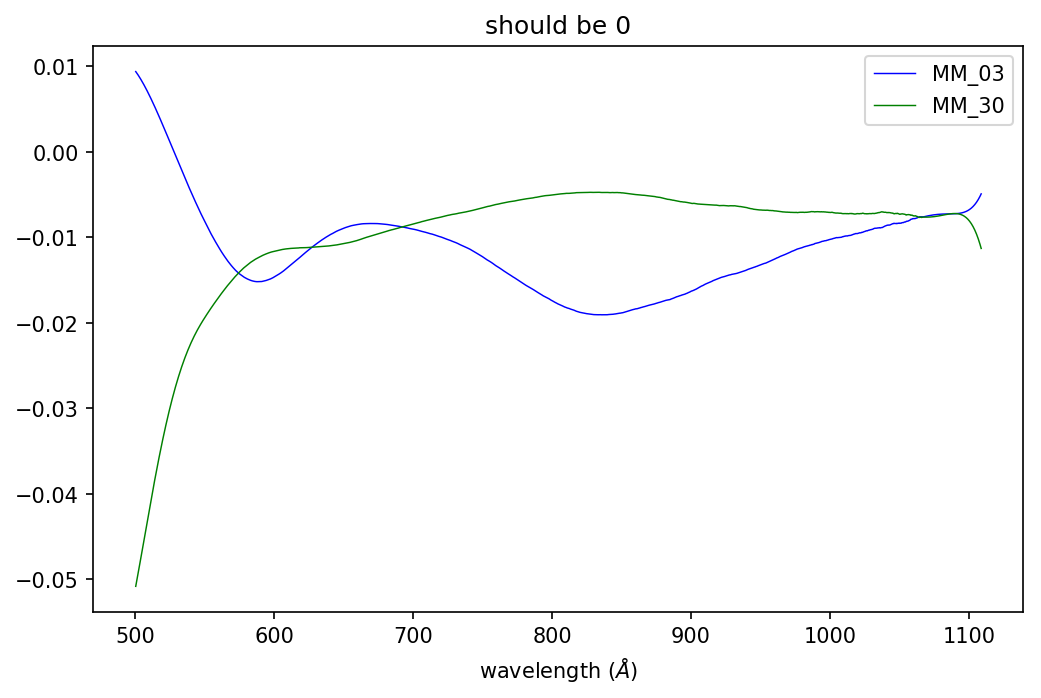

In [295]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 0, 3
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, mmFilter[:,c,r], '-g', linewidth=0.7, label="MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be 0")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]-mmFilter[:,c,r]).mean() )

what does this antiphase mean?

mean deviation :  0.0035887511451


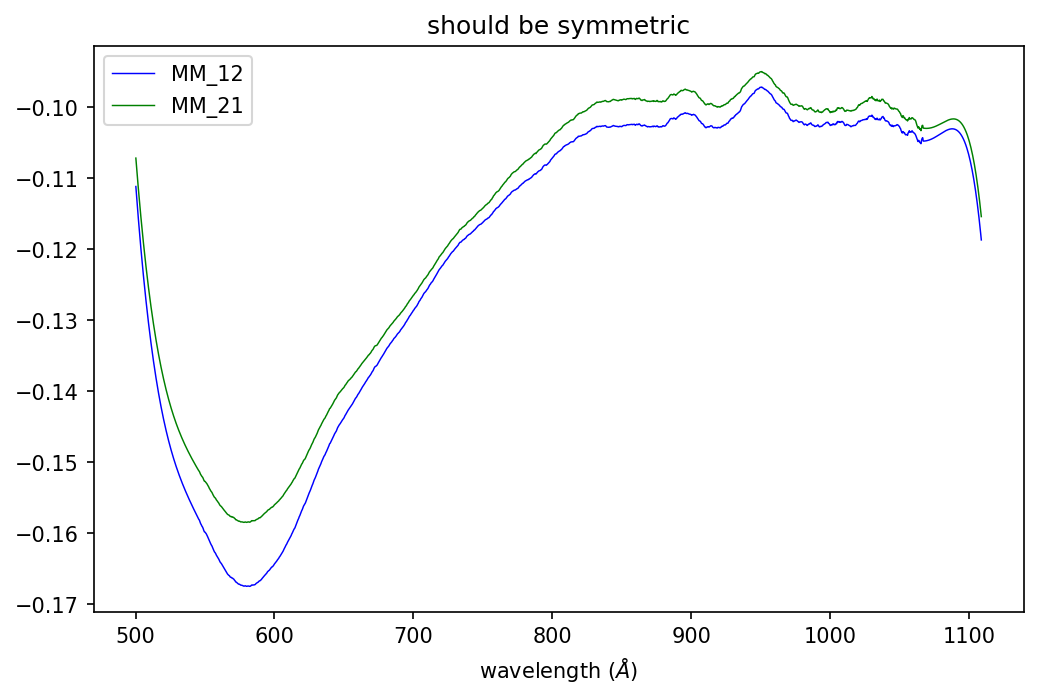

In [297]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 1, 2
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, mmFilter[:,c,r], '-g', linewidth=0.7, label="MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]-mmFilter[:,c,r]).mean() )

the phase is quite good 

mean deviation :  0.0242433530462


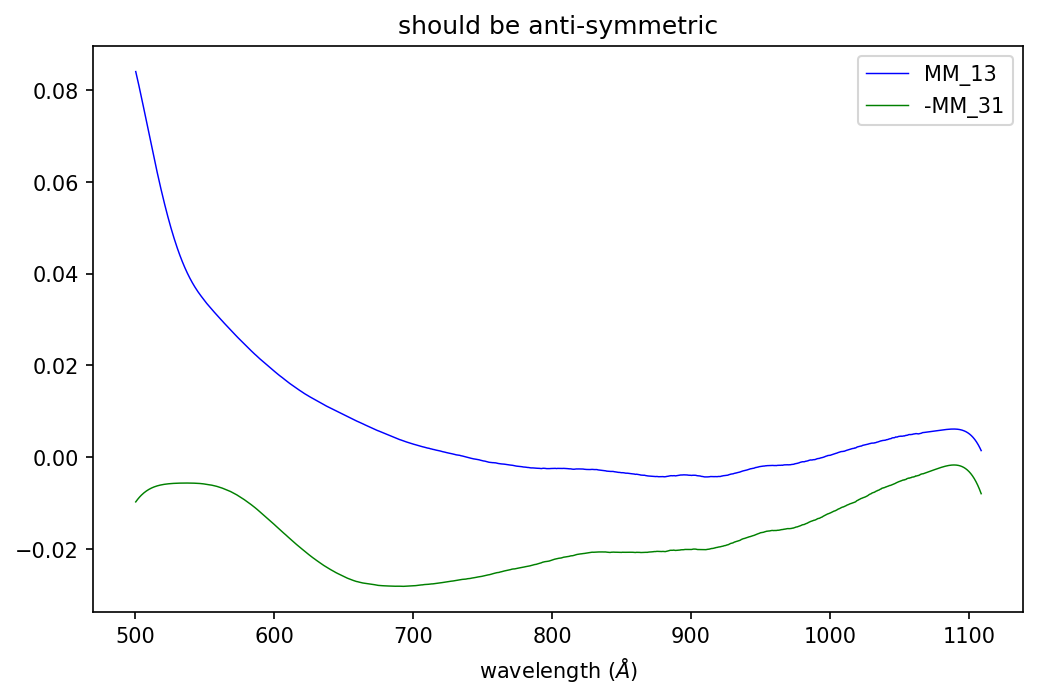

In [299]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 1, 3
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, -mmFilter[:,c,r], '-g', linewidth=0.7, label="-MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be anti-symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]+mmFilter[:,c,r]).mean() )

this is terrible

mean deviation :  0.00584030389654


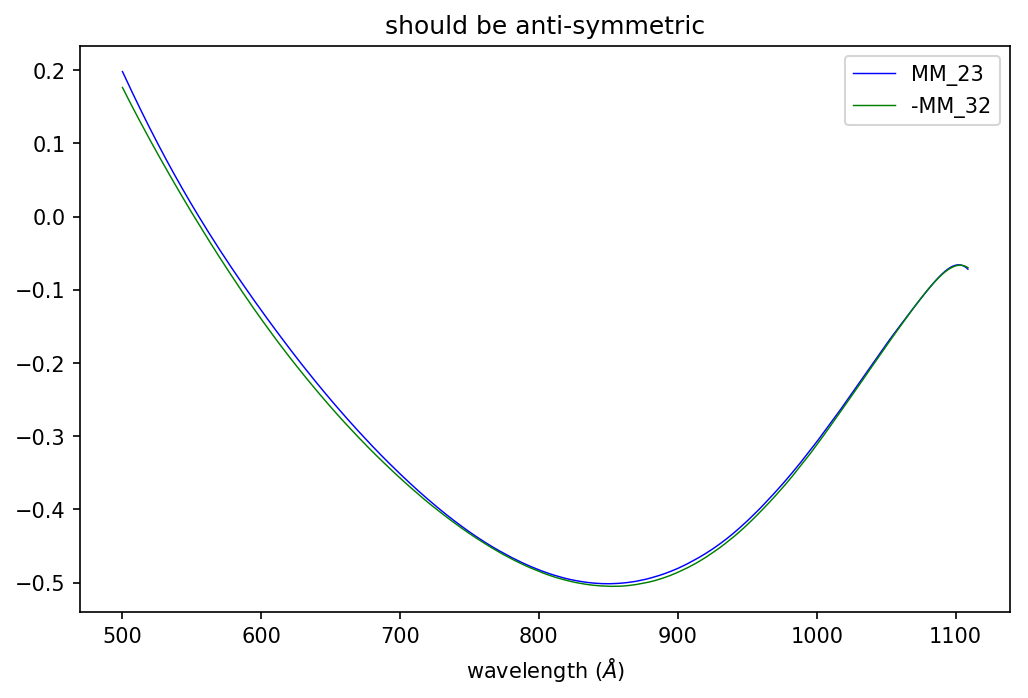

In [300]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 2, 3
ax.plot(wlFilter, mmFilter[:,r,c], '-b', linewidth=0.7, label="MM_{}{}".format(r,c))
ax.plot(wlFilter, -mmFilter[:,c,r], '-g', linewidth=0.7, label="-MM_{}{}".format(c,r))
ax.set_xlabel("wavelength ($\AA$)")
ax.set_title("should be anti-symmetric")
ax.legend(loc="best");

print("mean deviation : ", abs(mmFilter[:,r,c]+mmFilter[:,c,r]).mean() )

${mm}_{01}-{mm}_{10}$ and ${mm}_{02}-{mm}_{20}$

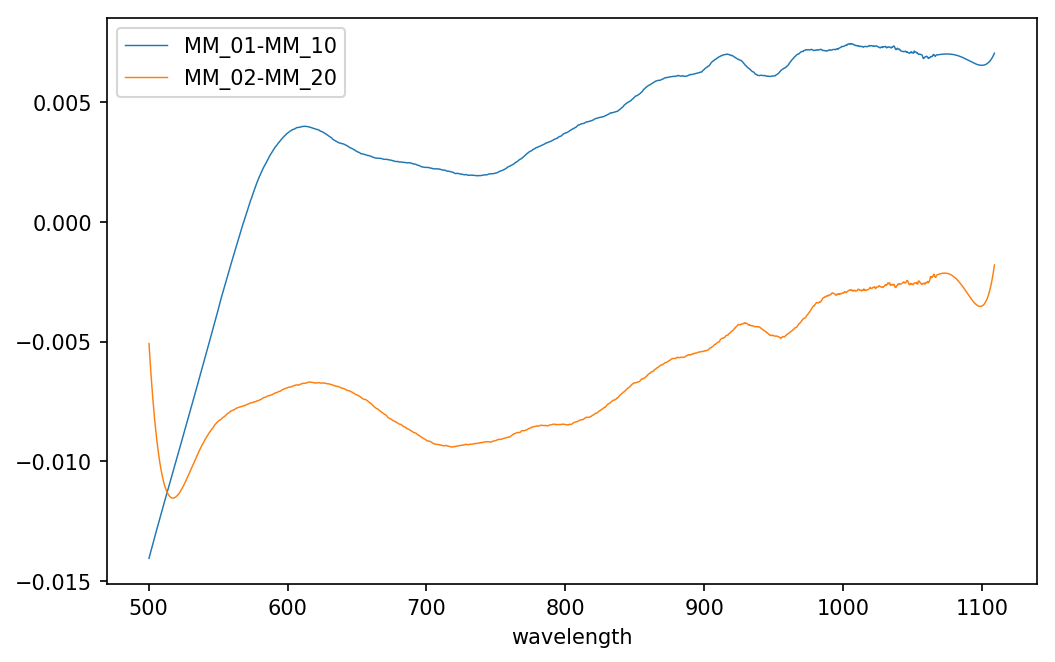

In [332]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 0, 1
ax.plot(wlFilter, mmFilter[:,r,c]-mmFilter[:,c,r], '-', linewidth=0.7, label="MM_{}{}-MM_{}{}".format(r,c,c,r))
r, c = 0, 2
ax.plot(wlFilter, mmFilter[:,r,c]-mmFilter[:,c,r], '-', linewidth=0.7, label="MM_{}{}-MM_{}{}".format(r,c,c,r))
ax.set_xlabel("wavelength")
ax.legend(loc="best");

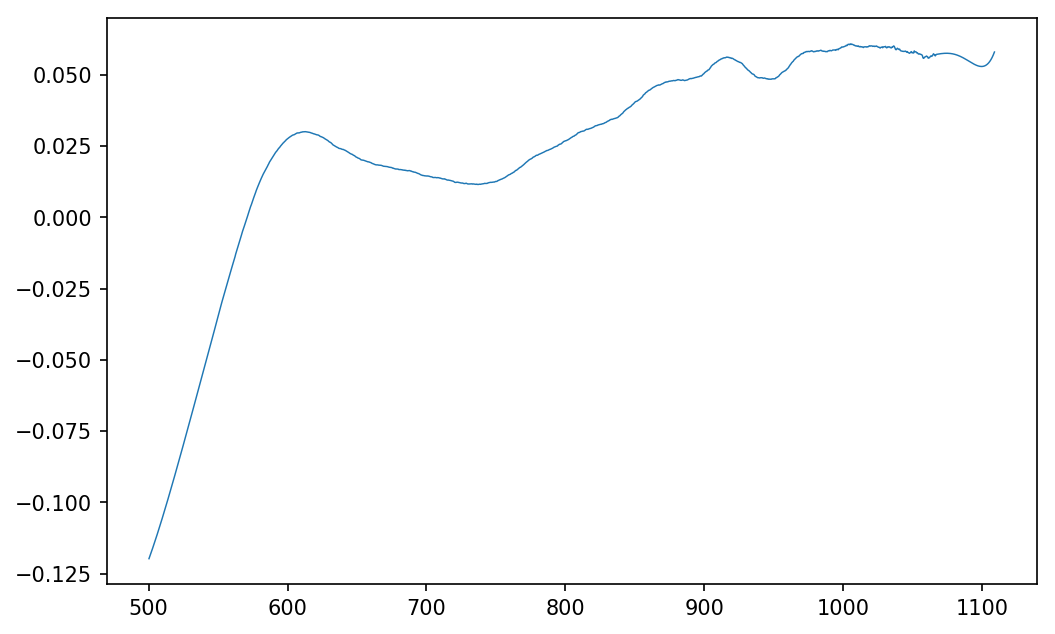

In [323]:
m01_m_m10 = ( (mmFilter[:,0,1]-mmFilter[:,1,0])*np.cos(2*0.03) + (mmFilter[:,0,2]-mmFilter[:,2,0])*np.sin(2*0.03)) / np.sin(4*0.03)
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.plot(wlFilter, m01_m_m10, '-', linewidth=0.7);

whether ${mm}_{00}+{mm}_{33}$ = ${mm}_{11}+{mm}_{22}$

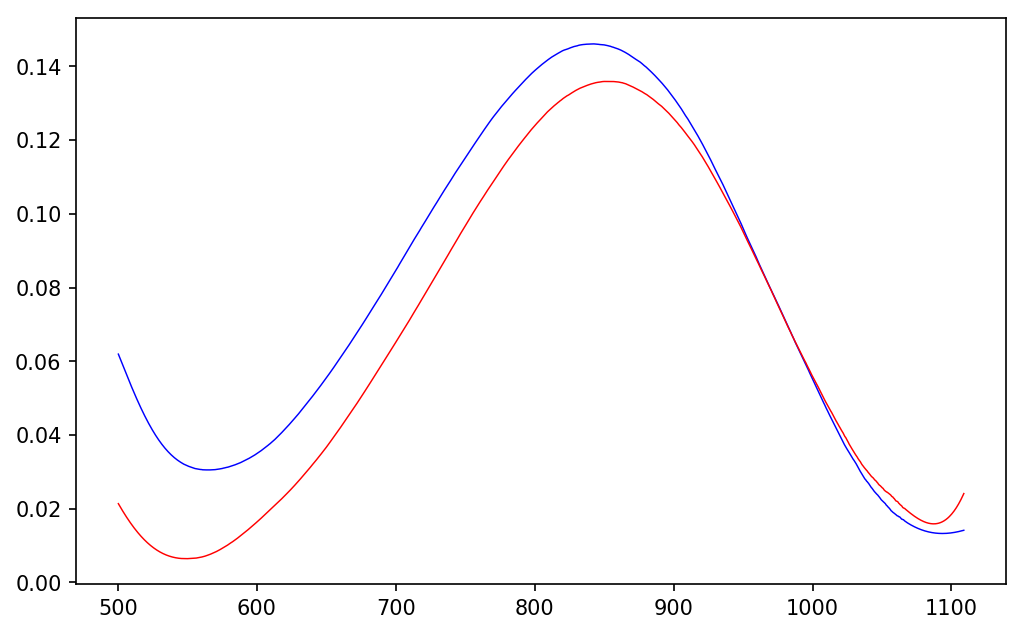

In [329]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.plot(wlFilter, mmFilter[:,0,0] + mmFilter[:,3,3], '-b', linewidth=0.7);
ax.plot(wlFilter, mmFilter[:,1,1] + mmFilter[:,2,2], '-r', linewidth=0.7);

depolarization exist?

whether ${mm}_{12}-{mm}_{21}=0$ because  ${mm}_{12}-{mm}_{21}={m}_{12}-{m}_{21}$ do not depend on $\theta$, the symmetry will not change

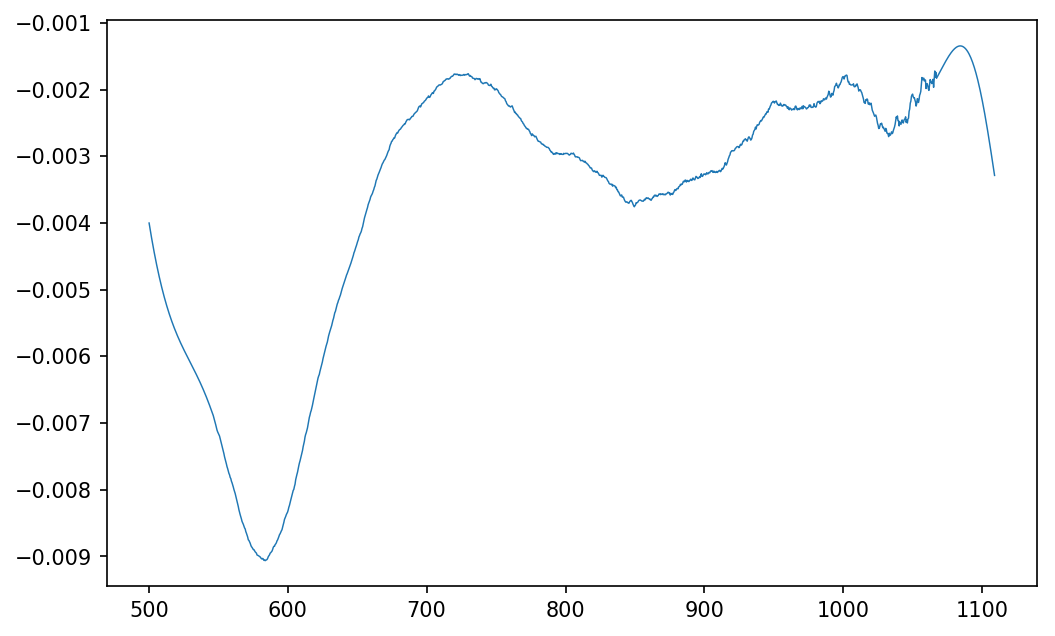

In [331]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
ax.plot(wlFilter, mmFilter[:,1,2] - mmFilter[:,2,1], '-', linewidth=0.7);
#ax.plot(wlFilter, mmFilter[:,1,1] + mmFilter[:,2,2], '-r', linewidth=0.7);

quite good beyond 7000A

${mm}_{13}+{mm}_{31}$ and ${mm}_{23}+{mm}_{32}$

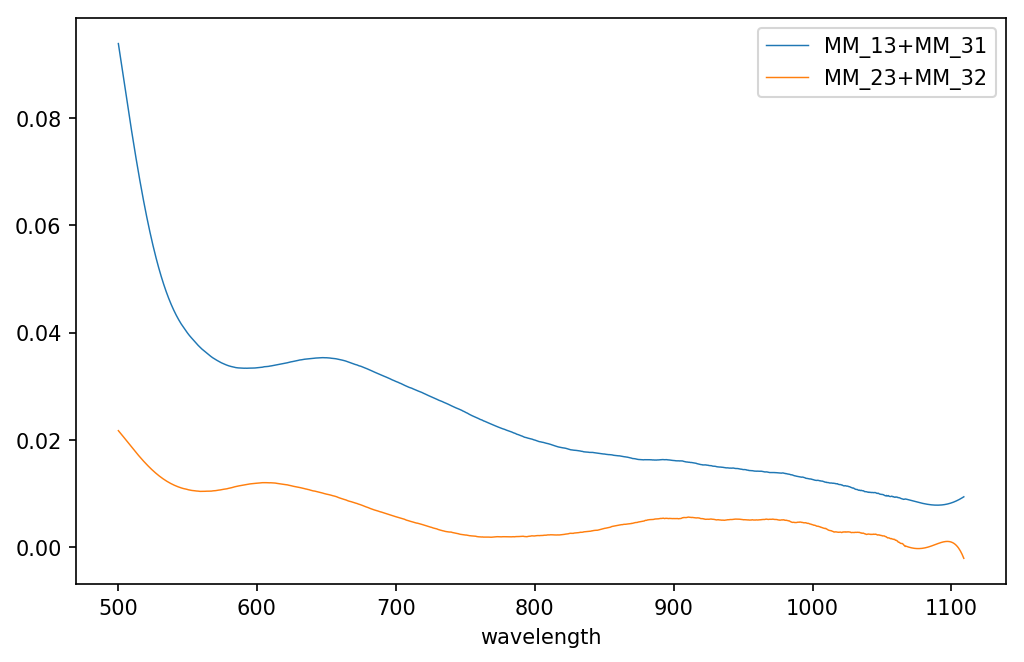

In [333]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 1, 3
ax.plot(wlFilter, mmFilter[:,r,c]+mmFilter[:,c,r], '-', linewidth=0.7, label="MM_{}{}+MM_{}{}".format(r,c,c,r))
r, c = 2, 3
ax.plot(wlFilter, mmFilter[:,r,c]+mmFilter[:,c,r], '-', linewidth=0.7, label="MM_{}{}+MM_{}{}".format(r,c,c,r))
ax.set_xlabel("wavelength")
ax.legend(loc="best");

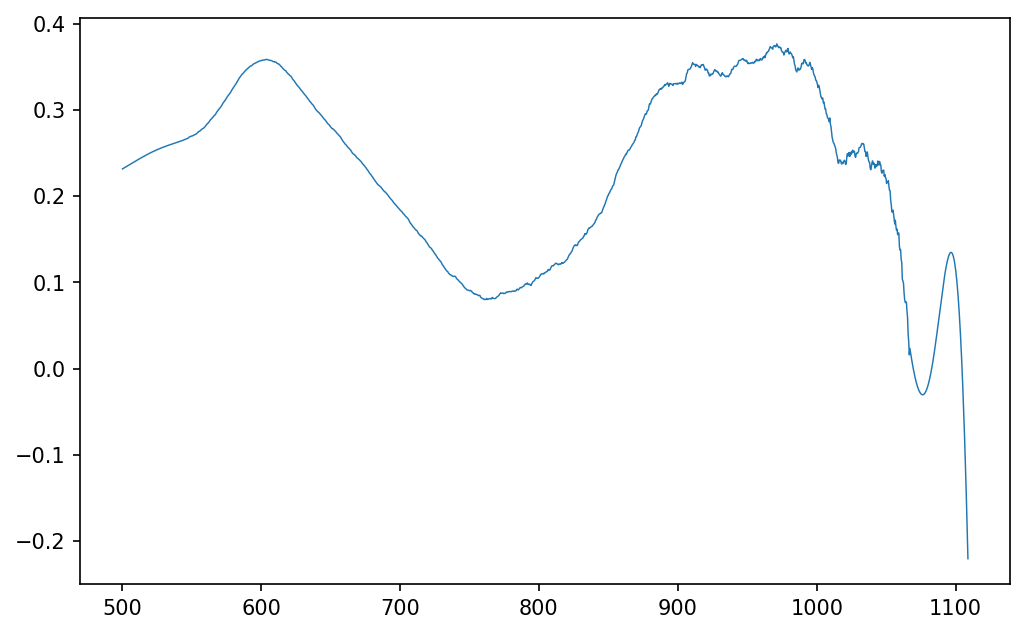

In [335]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
r, c = 1, 3
temp1 = mmFilter[:,r,c]+mmFilter[:,c,r]
r, c = 2, 3
temp2 = mmFilter[:,r,c]+mmFilter[:,c,r]
ax.plot(wlFilter, temp2/temp1, '-', linewidth=0.7);

# fit mm_45 

### a try

In [88]:
def residual(par, y_data):
    
    y_model = model(par)
    
    return y_model.reshape(-1) - y_data.reshape(-1)

def model(par):
    
    theta = par["theta"]
    delta = par["delta"]
    p = par["p"]
    
    mm_mir = MuellerMatrixMirror(delta,p,gen=True)
    mat = MuellerMatrixRotation(-theta) @ (mm_mir/mm_mir[0,0]) @ MuellerMatrixRotation(theta)
    
    return mat


params = lmfit.Parameters()
params.add( "theta", value=0, min=-1., max=1. ,vary=True)
params.add( "p", value=0, min=-0.5, max=0.5, vary=True )
params.add( "delta", value=0, min=-np.pi, max=np.pi, vary=True )

In [91]:
mm.shape

In [116]:
for i in [1500]:#range(x0,x1):
    print("wavelength : {} $\AA$".format(wl[i]*10))
    y_data = mm[i,:,:] / mm[i,0,0]
    result = lmfit.minimize(residual, params, args=(y_data,), method='leastsq')

wavelength : 8762.84 $\AA$


In [117]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # function evals   = 19
    # data points      = 16
    # variables        = 3
    chi-square         = 0.001
    reduced chi-square = 0.000
    Akaike info crit   = -148.778
    Bayesian info crit = -146.460
[[Variables]]
    theta:  -0.02574888 +/- 0.001611 (6.26%) (init= 0)
    p:      -0.03905532 +/- 0.006217 (15.92%) (init= 0)
    delta:   0.52523836 +/- 0.006227 (1.19%) (init= 0)


In [118]:
print(result.residual.reshape(4,4))

[[ 0.         -0.00335748  0.00338224  0.01664422]
 [ 0.00296718  0.00918545  0.00430567 -0.02079489]
 [-0.00148386  0.00105761 -0.00696523 -0.00575129]
 [ 0.00558129  0.0053791  -0.00083806 -0.00414477]]


### fit angle `theta` simultaneously

---

# Symbolic matrix analysis

In [107]:
result.params

Parameters([('theta',
  <Parameter 'theta', value=-0.030435644421859531 +/- 0.00211, bounds=[-1.0:1.0]>),
 ('p',
  <Parameter 'p', value=0.022068286671217296 +/- 0.00822, bounds=[-0.5:0.5]>),
 ('delta',
  <Parameter 'delta', value=0.44788029475203484 +/- 0.00822, bounds=[-3.141592653589793:3.141592653589793]>)])

In [101]:
print(result.residual.reshape(4,4))

[[ 0.          0.00584241  0.00722088 -0.00190281]
 [-0.00300424  0.01078939  0.00012955 -0.04446389]
 [-0.00407858 -0.00569508 -0.01426947 -0.00316556]
 [ 0.03156478 -0.01405783 -0.01091478 -0.03618005]]


In [317]:
sym.init_printing?

In [318]:
import sympy as sym
sym.init_printing(wrap_line=True)

## Mirror's Mueller Matrix 

In [64]:
delta, p = sym.symbols('delta, p')
delta, p

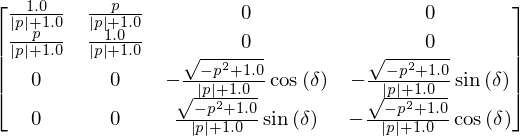

In [65]:
mm_mirror = sym.Matrix([
            [1., p, 0., 0.],
            [p, 1., 0., 0.],
            [0., 0., -sym.sqrt(1.-p*p)*sym.cos(delta), -sym.sqrt(1.-p*p)*sym.sin(delta)],
            [0., 0., +sym.sqrt(1.-p*p)*sym.sin(delta), -sym.sqrt(1.-p*p)*sym.cos(delta)]
        ]) / (1.+abs(p))
mm_mirror

## rotation matrix

In [78]:
def MuellerMatrixRotationSymbol(theta):
    
    # this assert will false if we input -theta
    # assert isinstance(theta, sym.Symbol), "argument theta must be a sympy.Symbol"
    
    c2 = sym.cos(2 * theta)
    s2 = sym.sin(2 * theta)
    
    mat = sym.Matrix([
        [1, 0  , 0 , 0 ],
        [0, c2 , s2, 0 ],
        [0, -s2, c2, 0 ],
        [0, 0  , 0 , 1 ]
    ])
    
    return mat

In [67]:
theta = sym.symbols("theta")
theta

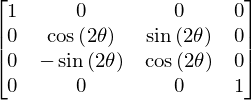

In [79]:
MuellerMatrixRotationSymbol(theta)

## Mueller Matrix of rotated Mirror

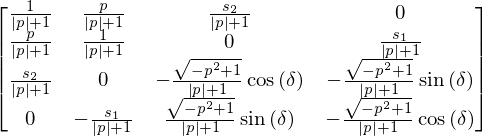

In [312]:
s1,s2 = sym.symbols("s1,s2")
mm_mirror = sym.Matrix([
            [1, p, s2, 0],
            [p, 1, 0, s1],
            [s2, 0, -sym.sqrt(1-p*p)*sym.cos(delta), -sym.sqrt(1-p*p)*sym.sin(delta)],
            [0, -s1, +sym.sqrt(1-p*p)*sym.sin(delta), -sym.sqrt(1-p*p)*sym.cos(delta)]
        ]) / (1+abs(p))
mm_mirror

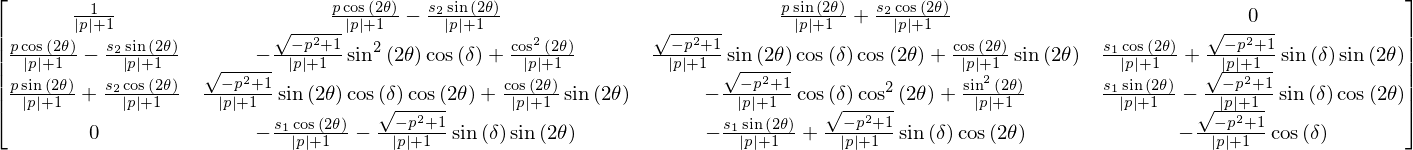

In [313]:
mm_mirror_rotated = MuellerMatrixRotationSymbol(-theta) * mm_mirror * MuellerMatrixRotationSymbol(theta)
mm_mirror_rotated 

original

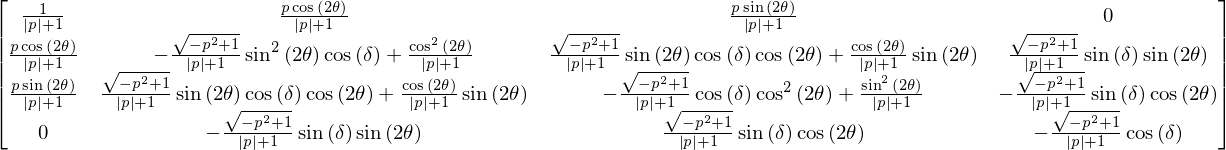

In [309]:
mm_mirror_rotated = MuellerMatrixRotationSymbol(-theta) * mm_mirror * MuellerMatrixRotationSymbol(theta)
mm_mirror_rotated 

we found that, if $\lim_{p \to 0, \theta \to 0}$

- $m_{02} = m_{20} \to (O^2)$
- $m_{03} = m_{30} = 0$
- $m_{12} = m_{21} \to (O^1)$
- $m_{13} = -m_{31} \ to (O^1)$

if a full 4x4 matrix is rotated

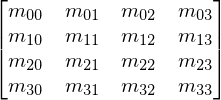

In [315]:
m00, m01, m02, m03, m10, m11, m12, m13, m20, m21, m22, m23, m30, m31, m32, m33 = sym.symbols("m00, m01, m02, m03, m10, m11, m12, m13, m20, m21, m22, m23, m30, m31, m32, m33")
mm_full = sym.Matrix([
    [m00, m01, m02, m03],
    [m10, m11, m12, m13],
    [m20, m21, m22, m23],
    [m30, m31, m32, m33]
])
mm_full

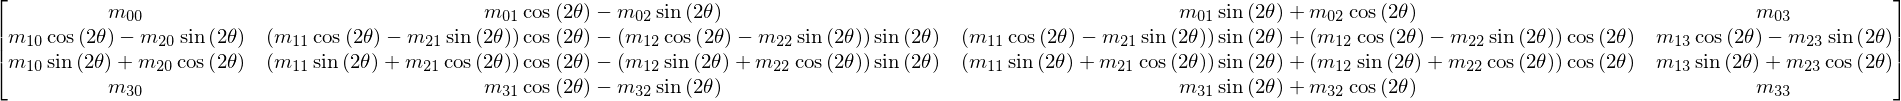

In [319]:
MuellerMatrixRotationSymbol(-theta) * mm_full * MuellerMatrixRotationSymbol(theta)

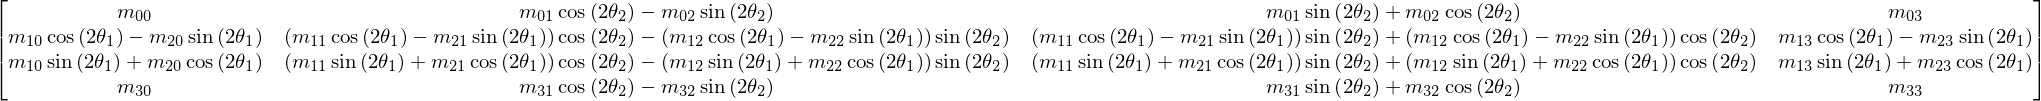

In [336]:
theta1, theta2 = sym.symbols("theta1, theta2")
MuellerMatrixRotationSymbol(-theta1) * mm_full * MuellerMatrixRotationSymbol(theta2)

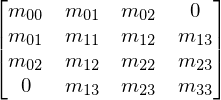

In [337]:
mm_sym = sym.Matrix([
    [m00, m01, m02, 0],
    [m01, m11, m12, m13],
    [m02, m12, m22, m23],
    [0, m13, m23, m33]
])
mm_sym

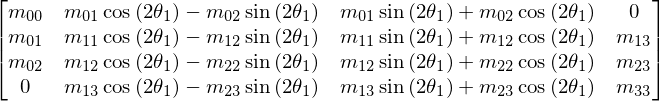

In [339]:
mm_sym * MuellerMatrixRotationSymbol(theta1)